XGBOOST

In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
file_path = "C:/Users/chimc/Desktop/Thomsun Infocare/capricorn UAT data/data2024.csv"
df = pd.read_csv(file_path,  encoding='ISO-8859-1')

In [3]:
# Convert invoice date to datetime format
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

# Extract date-based features
df['year'] = df['invoicedate'].dt.year
df['month'] = df['invoicedate'].dt.month
df['day'] = df['invoicedate'].dt.day
df['weekday'] = df['invoicedate'].dt.weekday

In [4]:
# Define features and target variable
X = df[['year', 'month', 'day', 'weekday', 'qty', 'avgunitprice', 'totaldiscount']]
y = df['salesamount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             learning_rate=0.1, 
                             max_depth=6, 
                             random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)


In [6]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
relative_error = (mae / np.mean(y_test)) * 100
pseudo_accuracy = 100 - relative_error

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Relative Error: {relative_error:.2f}%")
print(f"Pseudo-Accuracy (100 - Relative Error): {pseudo_accuracy:.2f}%")

Mean Absolute Error (MAE): 0.18
Mean Squared Error (MSE): 0.54
Root Mean Squared Error (RMSE): 0.73
R² Score: 1.00
Relative Error: 1.47%
Pseudo-Accuracy (100 - Relative Error): 98.53%


XGBOOST WITH LAGS

In [16]:
# Sort data by date
df = df.sort_values(by="invoicedate")

# Create lag features
df['sales_lag_1'] = df['salesamount'].shift(1)
df['sales_lag_7'] = df['salesamount'].shift(7)
df['sales_lag_30'] = df['salesamount'].shift(30)

# Fill missing values with 0 (optional: you can use mean or forward-fill)
df.fillna(0, inplace=True)


In [17]:
# One-hot encode the month column
df = pd.get_dummies(df, columns=['month'], prefix='month')

In [18]:
# Define features and target
X = df[['year', 'day', 'weekday', 'qty', 'avgunitprice', 'totaldiscount',
        'sales_lag_1', 'sales_lag_7', 'sales_lag_30'] + 
       [col for col in df.columns if col.startswith('month_')]]  # Include month dummies

y = df['salesamount']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             learning_rate=0.1, 
                             max_depth=6, 
                             random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)


In [20]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
relative_error = (mae / np.mean(y_test)) * 100
pseudo_accuracy = 100 - relative_error

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Relative Error: {relative_error:.2f}%")
print(f"Pseudo-Accuracy (100 - Relative Error): {pseudo_accuracy:.2f}%")

Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.85
Root Mean Squared Error (RMSE): 0.92
R² Score: 1.00
Relative Error: 1.37%
Pseudo-Accuracy (100 - Relative Error): 98.63%


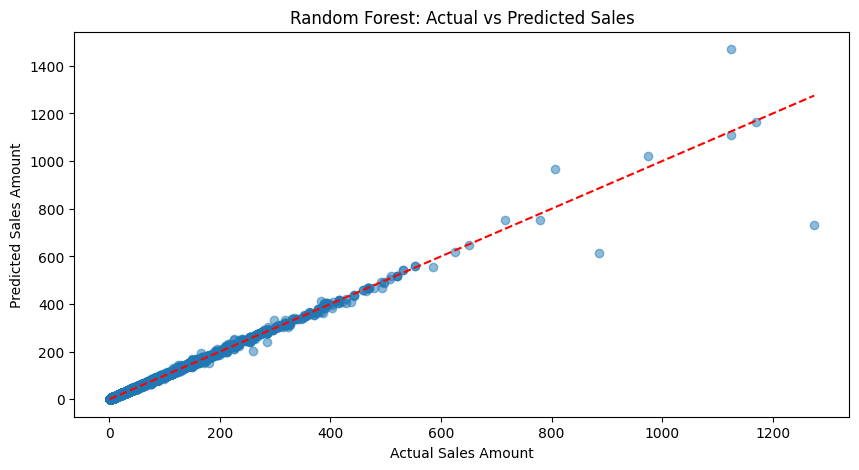

In [21]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Random Forest: Actual vs Predicted Sales")
plt.show()


HYPERPARAMETER TUNING

●-n_estimators: Number of boosting rounds (100-500)

●-max_depth: Depth of each tree (3-10)

●-learning_rate: Shrinks weights to prevent overfitting (0.01-0.3)

●-subsample: Percentage of data used per tree (0.5-1.0)

●-colsample_bytree: Percentage of features used per tree (0.5-1.0)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, 
                                   n_iter=20, scoring='neg_mean_squared_error', 
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)

# Train on the dataset
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [23]:
# Get best parameters

# Train final model with best params
xgb_best = xgb.XGBRegressor(
    subsample=0.7,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.7,
    objective='reg:squarederror',
    random_state=42
)
xgb_best.fit(X_train, y_train)

# Make predictions
y_pred = xgb_best.predict(X_test)


In [24]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
relative_error = (mae / np.mean(y_test)) * 100
pseudo_accuracy = 100 - relative_error

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Relative Error: {relative_error:.2f}%")
print(f"Pseudo-Accuracy (100 - Relative Error): {pseudo_accuracy:.2f}%")

Mean Absolute Error (MAE): 0.18
Mean Squared Error (MSE): 0.84
Root Mean Squared Error (RMSE): 0.92
R² Score: 1.00
Relative Error: 1.44%
Pseudo-Accuracy (100 - Relative Error): 98.56%


●-Reducing max_depth or subsample prevents overfitting to extreme values, lowering large squared errors but potentially making the model less precise for some points, increasing absolute errors.

●-A smaller learning_rate with more n_estimators (500) might generalize better, reducing outlier errors but slightly shifting predictions away from exact fits, raising MAE.

●-XGBoost optimized for reg:squarederror (MSE-based), not MAE. If you tuned hyperparameters using MSE as the evaluation metric in random_search, the resulting best_params_ prioritize reducing squared errors, not absolute errors.

●-But since the model is already performing near perfectly, hyperparameter tuning doesnt have much difference to make.